# CENG 483 THE 2

**Name: Aybüke Aksoy**

**Student ID: 2448090**


In [10]:
# Import libraries
import numpy as np
import cv2
import os
import scipy
import matplotlib.pyplot as plt
import time

def read_images():

    # Reading the images in the "images" folder 
    # and putting them into image_list.
    image_list=[]
    folder_path="images/"
    for image_path in os.listdir(folder_path):
        image = cv2.imread(os.path.join(folder_path, image_path))
        if image is not None:
            image_list.append(image)

    return image_list

image_list=read_images()

def non_max_suppression_window(window):

    # Suppressing the non-max values in the input window
    window_copy=np.copy(window)
    window_copy=window_copy.reshape(-1)
    # Getting the max value index in the window
    max_index=np.argmax(window_copy)
    # Finding the max value
    max_value=window_copy[max_index]
    suppressed_window=np.zeros(25)
    # Putting the max value to
    # the max value index of supressed window
    suppressed_window[max_index]=max_value
    suppressed_window=suppressed_window.reshape((5,5))

    return suppressed_window

def with_non_maximum_supression(E_list,image):

    # Number of rows and columns in the image
    rows,columns=image.shape[0],image.shape[1]

    # Traversing the E_list entries
    # and creating a 3x3 window 
    for row in range(2,rows-2):
        for col in range(2,columns-2):
                window=E_list[row-2:row+3,col-2:col+3]
                # Sending the window to non-max supp. function 
                # and getting the suppressed E values list
                E_list[row-2:row+3,col-2:col+3]=non_max_suppression_window(window)

    # Finding the indexes of max 10 values in the Error list
    max_indexes=np.argpartition(E_list.flatten(), -10)[-10:]
    # Finding the corresponding pixels in the image
    max_pixels_row=max_indexes//columns
    max_pixels_column=max_indexes%columns

    for i in range(10):
        cv2.circle(image,(max_pixels_column[i],max_pixels_row[i]),2, (255, 0, 0), -1)

    return image

def without_non_maximum_supression(E_list,image):

    columns=image.shape[1]
    # Finding the indexes of max 10 values in the Error list
    max_indexes=np.argpartition(E_list.flatten(), -10)[-10:]
    # Finding the corresponding pixels in the image
    max_pixels_row=max_indexes//columns
    max_pixels_column=max_indexes%columns

    for i in range(10):
        cv2.circle(image,(max_pixels_column[i],max_pixels_row[i]),2, (255, 0, 0), -1)

    return image

def naive_formula_window(image, row, col):

    # Window for the row,col pixel
    window1=image[row-1:row+2, col-1:col+2]
    # Shifting the window in 8 directions
    window2=image[row-2:row+1, col-2:col+1]
    window3=image[row-2:row+1, col-1:col+2]
    window4=image[row-2:row+1, col:col+3]
    window5=image[row-1:row+2, col:col+3]
    window6=image[row:row+3, col:col+3]
    window7=image[row:row+3, col-1:col+2]
    window8=image[row:row+3, col-2:col+1]
    window9=image[row-1:row+2, col-2:col+1]

    # Finding the errors by calculating the difference 
    # in intensity with each shifted window
    E1=np.sum(np.square(window2-window1))
    E2=np.sum(np.square(window3-window1))
    E3=np.sum(np.square(window4-window1))
    E4=np.sum(np.square(window5-window1))
    E5=np.sum(np.square(window6-window1))
    E6=np.sum(np.square(window7-window1))
    E7=np.sum(np.square(window8-window1))
    E8=np.sum(np.square(window9-window1))

    errors=np.array([E1,E2,E3,E4,E5,E6,E7,E8])

    # Returning the minimum intensity change
    # between 8 shift directions
    return min(abs(errors))

def harris_corner_naive_uniform(image):

    # Number of rows and columns in the image
    rows,columns=image.shape[0],image.shape[1]
    # Creating error list in the shape of image
    E_list=np.zeros((rows,columns))
    # Traversing the image pixel by pixel
    for row in range(2,rows-2):
        for col in range(2,columns-2):
            # Call to naive_formula_window for a specific pixel
            E_list[row,col]=naive_formula_window(image,row,col)
        
    # Returning the Error List
    return E_list

def fast_implementation_window(image,row,col,Ix2, Iy2, Ixy):

    #Experimentally chosen coefficient
    alpha=0.04

    Ix2_sum=np.sum(Ix2[row-1:row+2,col-1:col+2])
    Ixy_sum=np.sum(Ixy[row-1:row+2,col-1:col+2])
    Iy2_sum=np.sum(Iy2[row-1:row+2,col-1:col+2])

    #Calculation of cornerness function 
    R=Ix2_sum*Iy2_sum-np.square(Ixy_sum)-alpha*np.square((Ix2_sum+Iy2_sum))
    
    return R

def harris_corner_fast(image,weight):

    # Number of rows and columns in the image
    rows,columns=image.shape[0],image.shape[1]
    # Creating error list in the shape of image
    E_list=np.zeros((rows,columns))

    # Creating the window weighting filter
    if weight=="uniform":
        weight_filter=np.array([[1,1,1],[1,1,1],[1,1,1]])/9
    elif weight=="circular":
        weight_filter=np.array([[0,1,0],[1,1,1],[0,1,0]])/5
    elif weight=="gaussian":
        weight_filter=np.array([[1,2,1],[1,2,1],[1,2,1]])/12

    # Creating the derivative filters for x and y directions
    kernel_x = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
    kernel_y = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])

    # Convolution of the derivative filters with the image
    Ix = scipy.signal.convolve2d(image, kernel_x, mode='same',boundary='symm')
    Iy = scipy.signal.convolve2d(image, kernel_y, mode='same',boundary='symm')

    # Convolution of the weight filter with the image
    Ix=scipy.signal.convolve2d(Ix, weight_filter, mode='same',boundary='symm')
    Iy=scipy.signal.convolve2d(Iy, weight_filter, mode='same',boundary='symm')
    
    # Taking the square of intensity changes
    Ix2, Iy2, Ixy = np.square(Ix), np.square(Iy), Ix * Iy

    # Traversing the image pixel by pixel
    for row in range(1,rows-1):
        for col in range(1,columns-1):
            # Call to fast_implementation_window for a specific pixel
            E_list[row][col]=fast_implementation_window(image,row,col,Ix2,Iy2,Ixy)
            
    # Returning the Error List        
    return E_list
    

libpng warning: iCCP: known incorrect sRGB profile


## Naive Formula + Uniform Weighting (without Non-Maximum Suppression)

Average time taken: 3.72 seconds


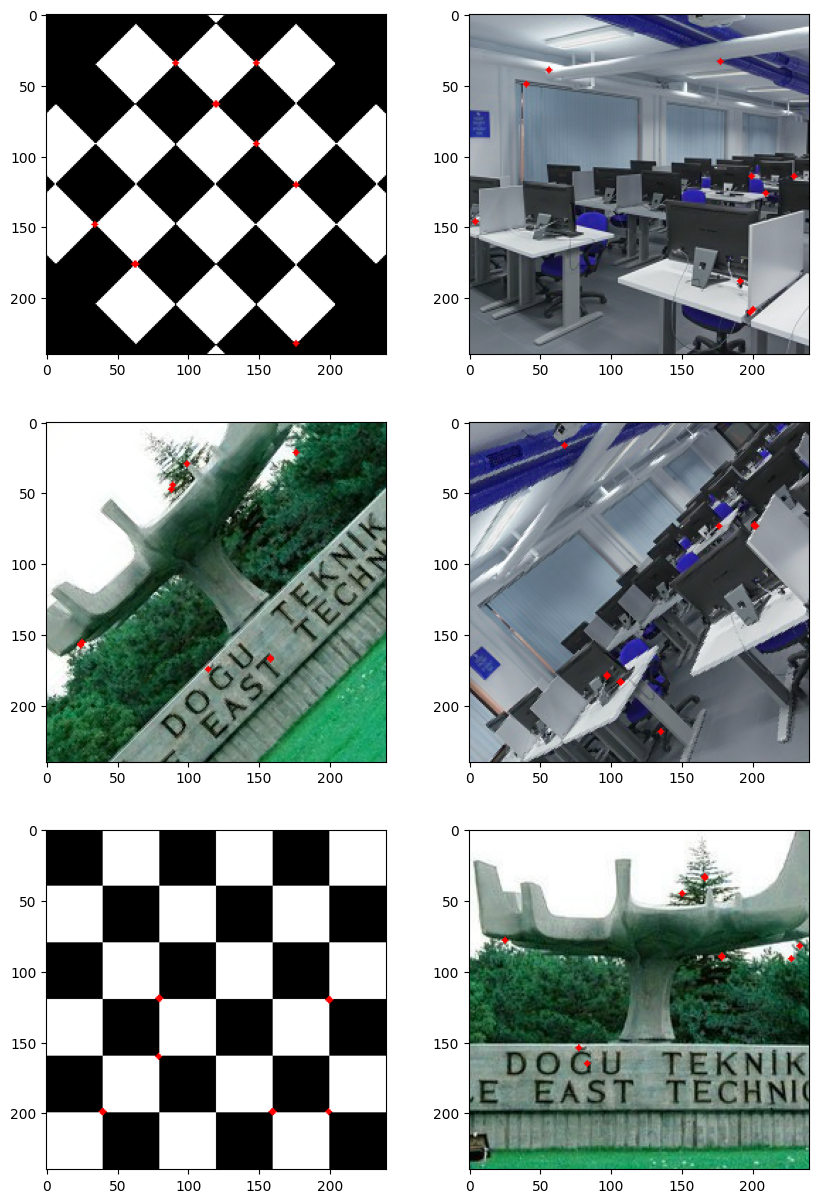

In [3]:

# The implementation of harris_corner_naive_uniform function 
# and without_non_maximum_supression function is 
# under the shared functionality part.

fig, axs = plt.subplots(3, 2, figsize=(10, 15))
time_taken=0
for i in range(len(image_list)):
    # Getting the copy of colored image
    image_copy_color=np.copy(image_list[i])
    # Converting the image to grayscale
    image_copy = cv2.cvtColor(image_copy_color, cv2.COLOR_BGR2GRAY)
    start=time.time()
    # Calculating the errors with naive formula
    E_list = harris_corner_naive_uniform(image_copy)
    # Finding the corner points without non-max suppression
    image_copy=without_non_maximum_supression(E_list,image_copy_color)
    end = time.time()
    time_taken+=end-start
    axs[i // 2, i % 2].imshow(image_copy)
avg_time=time_taken/6 
print("Average time taken: "+ str(avg_time.__format__('0.2f')) + " seconds")
    

This algorithm checks every pixel in the image to find the corner by measuring the similarities of the window and it's shifted version in different directions. This similarity value is computed by taking the sum of squared differences (SSD) between the corresponding pixels of two windows. 

In our naive formula implementation, we have considered 8 directions. Since only a discrete set of shifts are applied, the response is anisotropic. It highly depends on the direction, and it will be sensitive to rotation which makes this implementation rotation variant. As it is seen from the images, the corner points found from original images and rotated versions are mostly different. 

Since we have chosen a uniform weighting window with 3x3 size, the detector considers all pixels in the image with the same weight instead of prioritizing the close ones. This might result in a noisy response which can lead to false positives depending on the image. This can be seen on lab.png and tree.png and their rotated images. 

Also, naive implementation is very sensitive to edges as it only considers the minimum E between all 8 shift comparisons. This causes detection of edges instead of corners as it can be seen from lab.png and it's rotated version. 

Since we haven't done non-maximum suppression on the errors, we cannot retain the most significant response in the pixel neighborhood. Hence, we will get multiple responses for one corner and have poor localization which creates corners that are very close to eachother. 

The average time taken for each image in Naive formula without non-maximum supression is 3.81 seconds. This method has lower accuracy, and more computational time than the other ones due to the shifts calculations in 8 directions. 

## Naive Formula + Uniform Weighting

Average time taken: 3.96 seconds


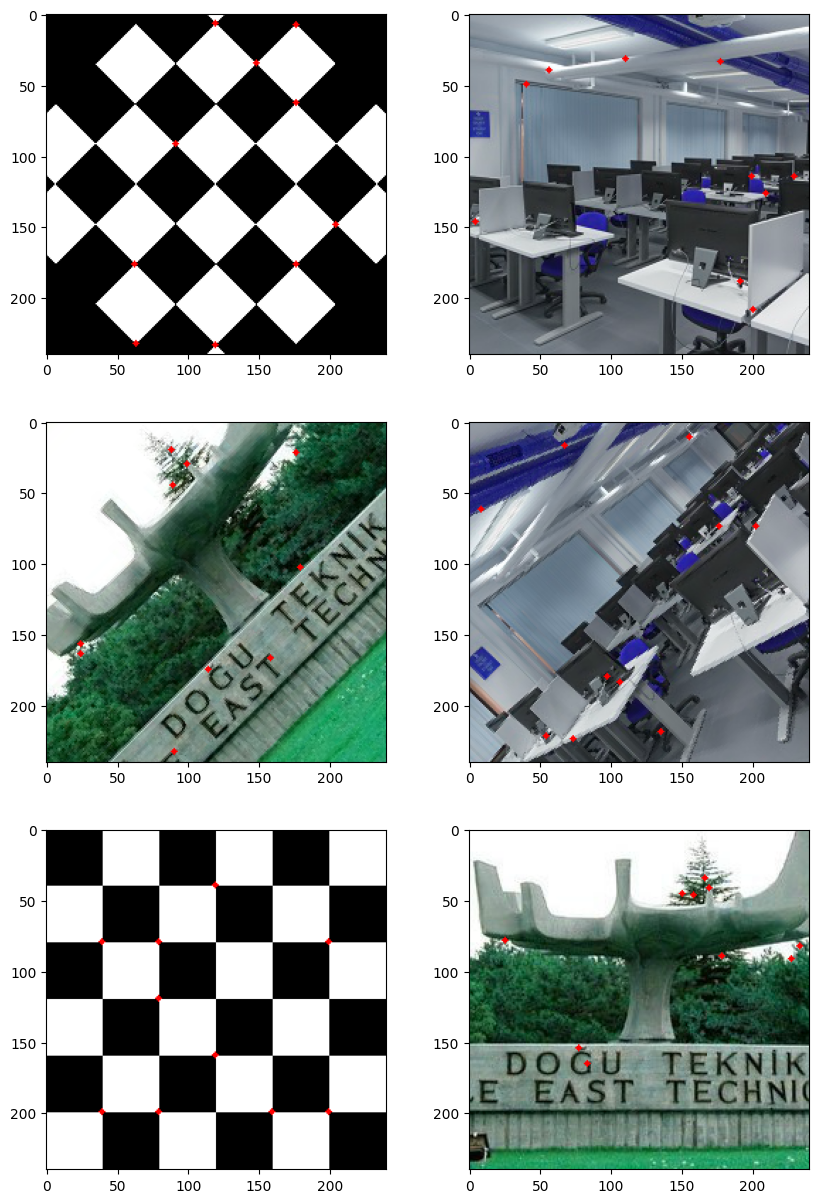

In [4]:
# The implementation of harris_corner_naive_uniform function 
# and with_non_maximum_supression function is 
# under the shared functionality part.

fig, axs = plt.subplots(3, 2, figsize=(10, 15))
time_taken=0
for i in range(len(image_list)):
    # Getting the copy of colored image
    image_copy_color=np.copy(image_list[i])
    # Converting the image to grayscale
    image_copy = cv2.cvtColor(image_copy_color, cv2.COLOR_BGR2GRAY)
    start=time.time()
    # Calculating the errors with naive formula
    E_list = harris_corner_naive_uniform(image_copy)
    image_copy=with_non_maximum_supression(E_list,image_copy_color)
    end = time.time()
    time_taken+=end-start
    axs[i // 2, i % 2].imshow(image_copy)
avg_time=time_taken/6 
print("Average time taken: "+ str(avg_time.__format__('0.2f')) + " seconds")


Sensitiveness to direction, noise and edges are the same for this implementation due to the reasons I have explained above. However, since non-maximum supression is applied, only the local maximum of the neighborhood is taken into account and is compared with other pixel E values. This helps to have single response for a single corner and reduces poor localization. As it can be seen from all images, the corner points found are further away from each other compared to naive formula's implementation without non-maximum suppression.

The average time taken for each image in Naive formula with non-maximum supression is 4.07 seconds. This method has better performance than the other naive approach but still not accurate enough and also has the additional computation coming from non-maximum suppression. It is the computationally most expensive one. 

## Taylor's Approximation + Uniform Weighting

Average time taken: 3.39 seconds


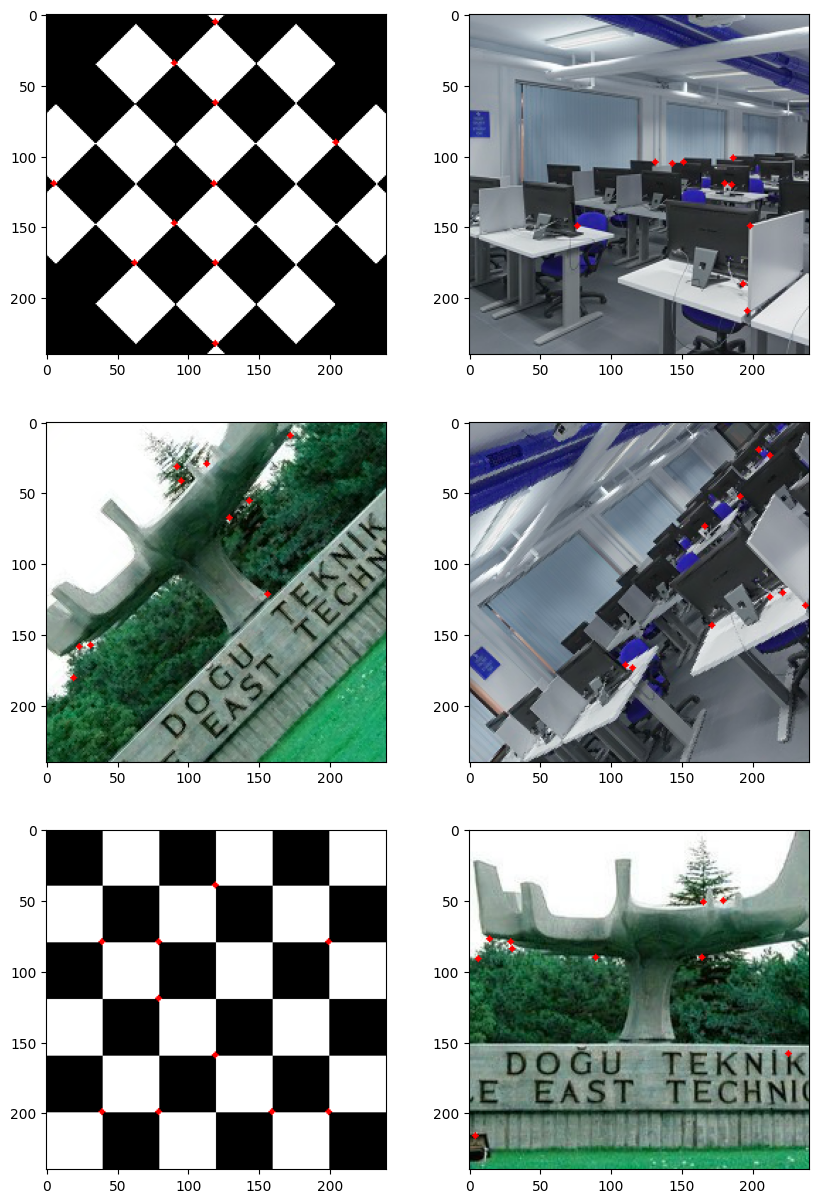

In [5]:

def taylor_formula_window(image,row,col,Ix2, Iy2, Ixy):
    
    # Taking the square of intensity changes
    Ix2_sum=np.sum(Ix2[row-1:row+2,col-1:col+2])
    Ixy_sum=np.sum(Ixy[row-1:row+2,col-1:col+2])
    Iy2_sum=np.sum(Iy2[row-1:row+2,col-1:col+2])
    errors=np.zeros(8)
    index=0
    
    # Applying taylor formula on 8 u,v pairs
    for u in range(-1,2):
        for v in range(-1,2):
            if(not (u==0 and v==0)):
                # Calculating the error by taylor approximation formula 
                errors[index]=(u**2)*Ix2_sum + 2*u*v*Ixy_sum + (v**2)*Iy2_sum
                index+=1

    #Returning the minimum error between 8 directions
    return np.min(abs(errors))

def harris_corner_taylor_uniform(image):
    
    # Number of rows and columns in the image
    rows,columns=image.shape[0],image.shape[1]
    # Creating error list in the shape of image
    E_list=np.zeros((rows,columns))

    # Creating the derivative filters for x and y directions
    kernel_x = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
    kernel_y = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])

    # Convolution of the derivative filters with the image
    Ix = scipy.signal.convolve2d(image, kernel_x, mode='same',boundary='symm')
    Iy = scipy.signal.convolve2d(image, kernel_y, mode='same',boundary='symm')
    Ix2, Iy2, Ixy = np.square(Ix), np.square(Iy), Ix * Iy

    # Traversing the image pixel by pixel
    for row in range(1,rows-1):
        for col in range(1,columns-1):
            # Call to taylor_formula_window for a specific pixel
            E_list[row][col]=taylor_formula_window(image,row,col,Ix2, Iy2, Ixy)
    
    # Returning the Error List 
    return E_list

fig, axs = plt.subplots(3, 2, figsize=(10, 15))
time_taken=0
for i in range(len(image_list)):
    # Getting the copy of colored image
    image_copy_color=np.copy(image_list[i])
    # Converting the image to grayscale
    image_copy = cv2.cvtColor(image_copy_color, cv2.COLOR_BGR2GRAY)
    start=time.time()
    # Calculating the errors with taylor approx. formula
    E_list = harris_corner_taylor_uniform(image_copy)
    image_copy=with_non_maximum_supression(E_list,image_copy_color)
    end = time.time()
    time_taken+=end-start
    axs[i // 2, i % 2].imshow(image_copy)
avg_time=time_taken/6 
print("Average time taken: "+ str(avg_time.__format__('0.2f')) + " seconds")


In this approach, first order taylor series approximation is applied on the naive formula. Our intensities in the window does not change with respect to our shift direction. By multiplying the intensity change matrix with u,v in each direction, we can get the error for the window. 

As in naive implementation, taylor series approximation also depends on discrete set of directions. Therefore, it will be sensitive to rotation and will find different corner points on the original and rotated image. 

The biggest difference from naive formula implementation is that we are using the 3x3 derivative filters on x and y direction to find the intensity change in the window. Since only 2 directions are applied, this filters are less robust on oblique directions. For this reason, it misses out some of the corners it has found in the original image, in the rotated image. This can be seen from the lab.png and it's rotated version. 

I was expecting this implementation to be sensitive to edges as well, since we have taken the minimum E from the set of E's in all u,v direction pairs. However, I could not observe such behaviour. Even if this is an approach that relies on approximations which led me to think that it would be less accurate than the naive approach, due to the limitations of naive approach on varying patterns and orientations, taylor approximation method found more reliable corners in scenarios with complex image structures. This can be observed from the results on images such as lab.png and tree.png and their rotated versions. 

Last of all, uniform weighting and non-maximum suppression is used, and their effects on the results are explained in the previous part. 

The average time taken for each image in Taylor approximation with non-maximum supression is 2.00 seconds. This method has better accuracy performance than the other naive approaches and also computationally less expensive with respect to the naive formula as we are calculating the intensity changes once for every window with the help of approximation. 

## Fast Implementation + Uniform Weighting

Average time taken: 1.32 seconds


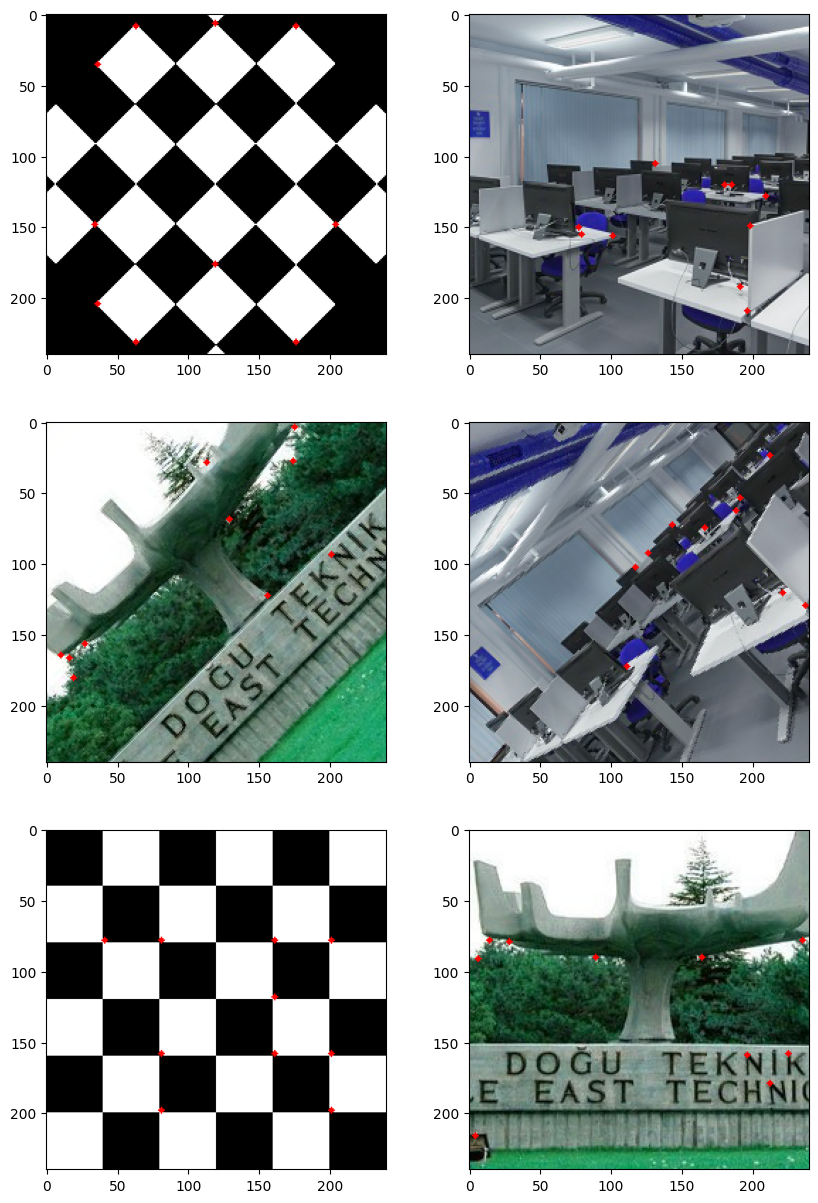

In [11]:
# The implementation of harris_corner_fast function 
# and with_non_maximum_supression function is 
# under the shared functionality part.

fig, axs = plt.subplots(3, 2, figsize=(10, 15))
time_taken=0
for i in range(len(image_list)):
    # Getting the copy of colored image
    image_copy_color=np.copy(image_list[i])
    # Converting the image to grayscale
    image_copy = cv2.cvtColor(image_copy_color, cv2.COLOR_BGR2GRAY)
    start=time.time()
    # Calculating the errors with fast implementation
    E_list = harris_corner_fast(image_copy,"uniform")
    image_copy=with_non_maximum_supression(E_list,image_copy_color)
    end = time.time()
    time_taken+=end-start
    axs[i // 2, i % 2].imshow(image_copy)
avg_time=time_taken/6 
print("Average time taken: "+ str(avg_time.__format__('0.2f')) + " seconds")


The fast implementation method finds the intensity changes in the window by using the 3x3 derivative filters in x and y direction. Then, it computes the determinant and trace of the H matrix that includes those intensity chnages, instead of shifting the window and calculating 8 errors depending on the shift direction. The computation of the R function which is the cornerness score, is the approximation of eigenvalues of the H matrix. 

Since we are not considering discrete set of shift directions, the response is less sensitive to rotation than the naive formula and taylor approximation approach even if it is still not rotation invariant. Also when we rotate the image, their eigenvalues are rotated but their magnitudes do not change, this is a characteristic that helps with sensitiveness to rotation. 

It is still less robust on oblique directions as in the case of Taylor approximation method due to the usage of 3x3 derivative filters. Hence, the cornerness score of the same corner pixel might change in the rotated image. This can be observed again in the lab.png and, tree.png and rotated versions. 

As we are only computing one R value(cornerness score) for each window and not taking the minimum E of 8 shifts, this method is not sensitive to edges and does not misidentify the edges as corners which is compliant with our expectations. 

Specific to the implementation with uniform weighting, method is still sensitive to the noise due to the reasons explained before. This can be improved by change of window weight. Also, non-maximum supression is used and it reduces multiple response for a corner. Thus, we have 10 distinct corners which are sparsely distributed. 

Overall, Fast implementation of harris corner detector preserves accuracy to an acceptable extent even if it uses approximation for eigenvalues. 

The average time taken for each image in Fast implementation with any weighting is around 1.32 seconds. This method is accurate enough for our implementations and has better accuracy performance than the naive approach. It is computationally the least expensive one as we are not calculating the intensity changes for u,v directions in each window but only approximate the eigenvalues of the H matrix. 

## Fast Implementation + Circular Weighting

Average time taken: 1.32 seconds


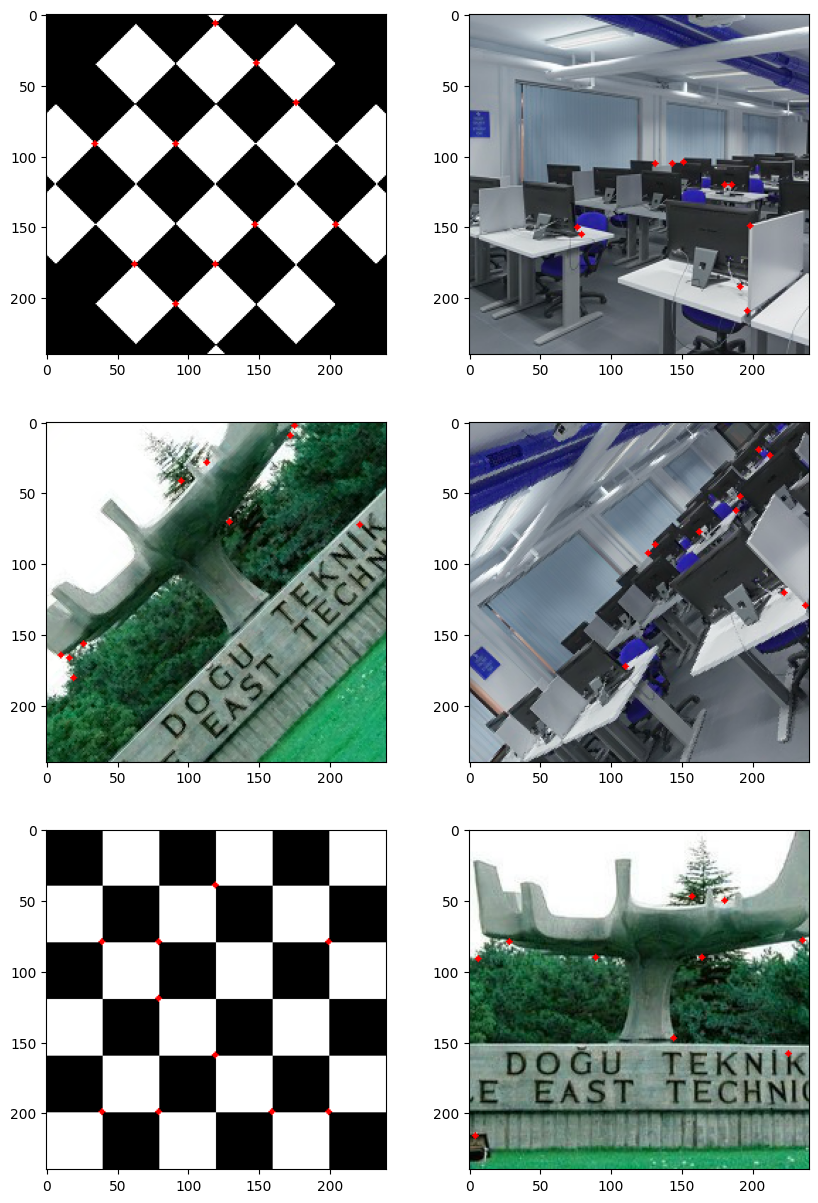

In [12]:
# The implementation of harris_corner_fast function 
# and with_non_maximum_supression function is 
# under the shared functionality part.

fig, axs = plt.subplots(3, 2, figsize=(10, 15))
time_taken=0
for i in range(len(image_list)):
    # Getting the copy of colored image
    image_copy_color=np.copy(image_list[i])
    # Converting the image to grayscale
    image_copy = cv2.cvtColor(image_copy_color, cv2.COLOR_BGR2GRAY)
    start=time.time()
    # Calculating the errors with fast implementtion
    E_list = harris_corner_fast(image_copy,"circular")
    image_copy=with_non_maximum_supression(E_list,image_copy_color)
    end = time.time()
    time_taken+=end-start
    axs[i // 2, i % 2].imshow(image_copy)
avg_time=time_taken/6 
print("Average time taken: "+ str(avg_time.__format__('0.2f')) + " seconds")



The general approach is the same with previous part. However, window weight function is replaced with circular weighting. The circular weighting places emphasis on the local structure within a circular region around the pixel of interest. Only pixels within the circular mask contribute to the computation, ignoring those outside the circle. 

This allows the Harris corner detector to focus on the local image features present within a circular region, and this can contribute to noise reduction and edge sensitivity reduction. This feature might be useful in accurately identifying images with complex texture or noise.

On the other hand, circular weighting might lose some potentially useful information from pixels further away from the center as it assigns 0 value to those pixels and directly discards them. This may lead to some corners being missed, especially the ones that are less localized or have elongated shapes.

The average time taken for each image in Fast implementation with circular weighting is 1.32 seconds and very close to the other Fast implementations with different weighting. We can conclude that the weighting has no effect on the computation cost. 

## Fast Implementation + Gaussian Weighting

Average time taken: 1.30 seconds


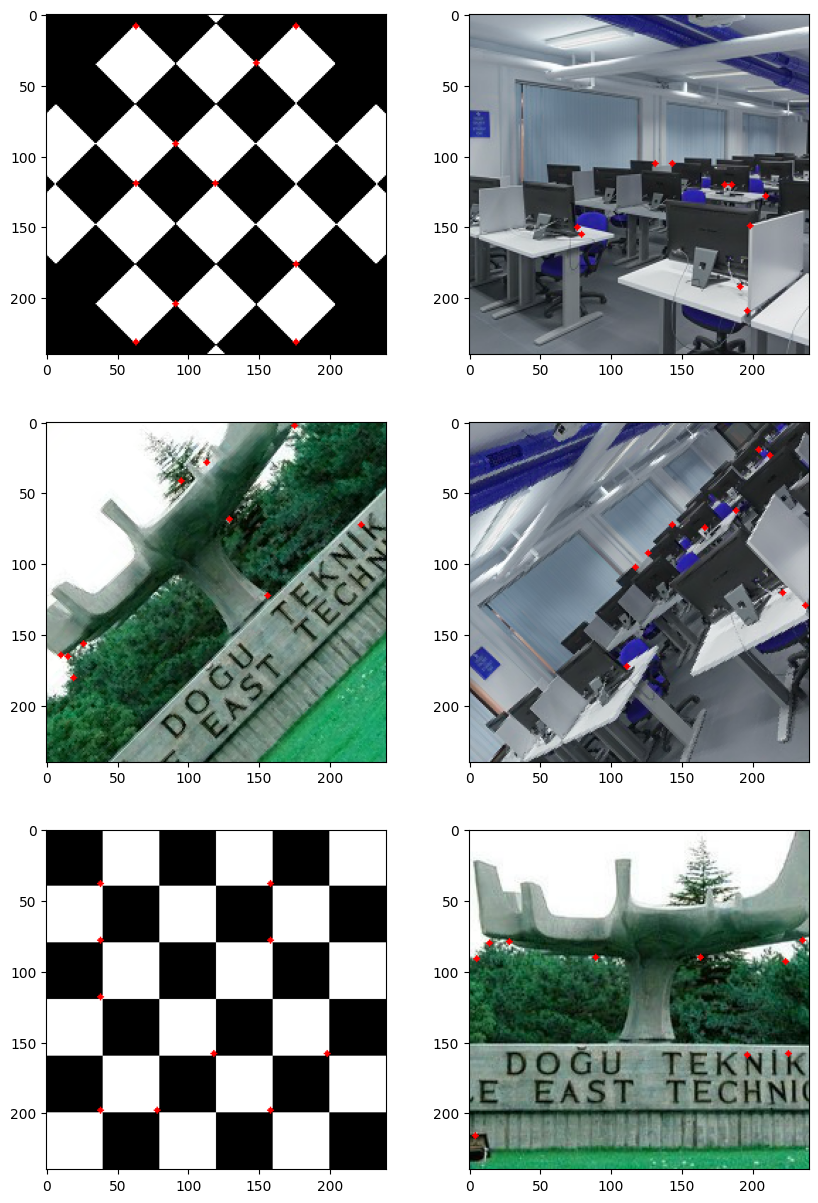

In [13]:
# The implementation of harris_corner_fast function 
# and with_non_maximum_supression function is 
# under the shared functionality part.

fig, axs = plt.subplots(3, 2, figsize=(10, 15))
time_taken=0
for i in range(len(image_list)):
    # Getting the copy of colored image
    image_copy_color=np.copy(image_list[i])
    # Converting the image to grayscale
    image_copy = cv2.cvtColor(image_copy_color, cv2.COLOR_BGR2GRAY)
    start=time.time()
    # Calculating the errors with fast implementation
    E_list = harris_corner_fast(image_copy,"gaussian")
    image_copy=with_non_maximum_supression(E_list,image_copy_color)
    end = time.time()
    time_taken+=end-start
    axs[i // 2, i % 2].imshow(image_copy)
avg_time=time_taken/6 
print("Average time taken: "+ str(avg_time.__format__('0.2f')) + " seconds")



The general approach is the same with other Fast implementation parts, yet the method with Gaussian weighting is an improved version. Gaussian weighting assigns higher weights to pixels closer to the center and gradually decreases weight with increasing distance.

This way of weighting has a smoothing effect on the local neighbourhood which tends to reduce the impact of high-frequency noise and make it less sensitive to high intensity changes. 

The aim of circular and gaussian weighting are indeed very similar, however gaussian function ensures retaining information from pixels slightly further away by introducing a smoother weight transition compared to the abrupt cutoff and discarding in the circular window. 

In summary, Gaussian weighting contributes to improved corner localization and rotation invariance by emphasizing the central region of the local neighborhood. It is more reliable and provides good balance between sensitivity and robustness compared to other weighting options such as uniform and circular weighting. 

The average time taken for each image in Fast implementation with gaussian weighting is 1.30 seconds and very close to the other Fast implementations with different weighting. We can conclude that the weighting has no effect on the computation cost. 

## Fast Implementation + Gaussian Weighting + RGB Split

Average time taken: 3.39 seconds


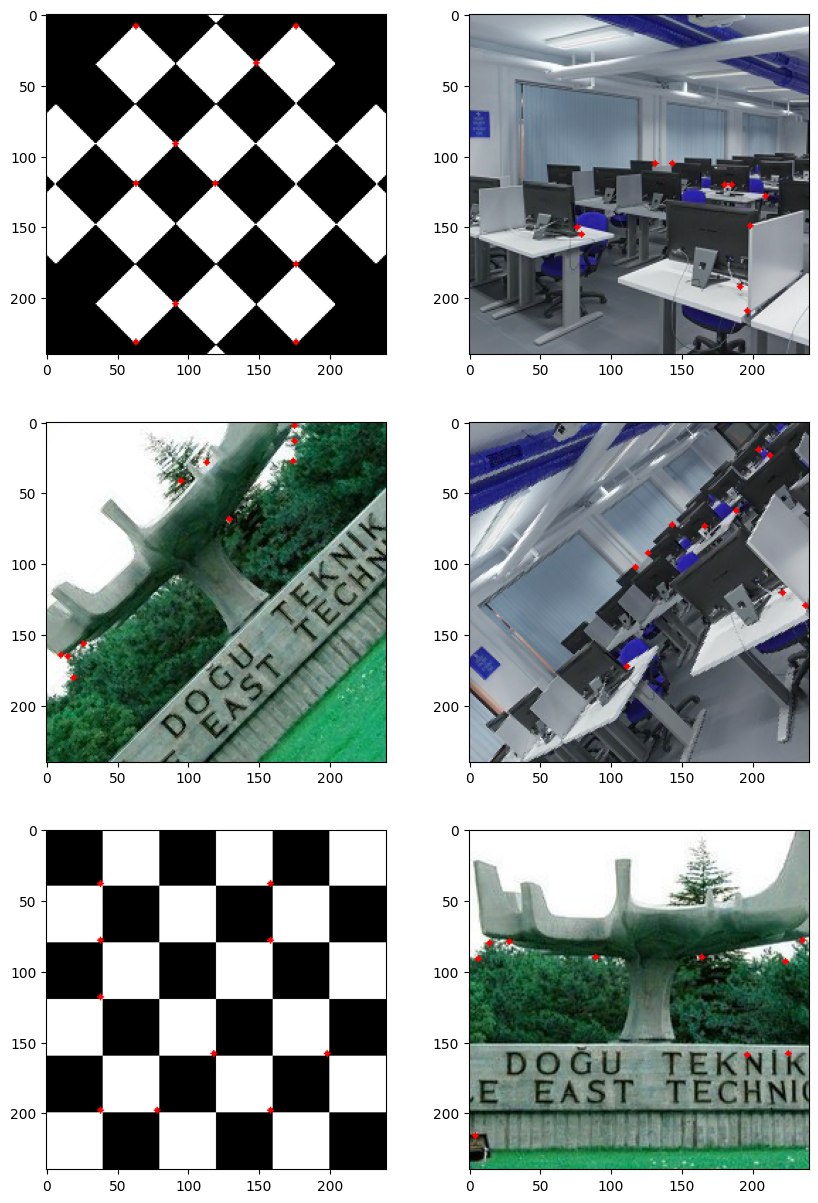

In [14]:
# The implementation of harris_corner_fast function 
# and with_non_maximum_supression function is 
# under the shared functionality part.

time_taken=0
fig, axs = plt.subplots(3, 2, figsize=(10, 15))
for i in range(len(image_list)):
    image_copy_color=np.copy(image_list[i])
    R=image_copy_color[:,:,2]
    G=image_copy_color[:,:,1]
    B=image_copy_color[:,:,0]
    start=time.time()
    # Calculating the errors for each color channel 
    # with fast implementation
    E_listR = harris_corner_fast(R,"gaussian")
    E_listG = harris_corner_fast(G,"gaussian")
    E_listB = harris_corner_fast(B,"gaussian")
    E_listRGB=E_listR+E_listG+E_listB
    image_copy=with_non_maximum_supression(E_listRGB,image_copy_color)
    end=time.time()
    time_taken+=end-start
    axs[i // 2, i % 2].imshow(image_copy)
avg_time=time_taken/6
print("Average time taken: "+ str(avg_time.__format__('0.2f')) + " seconds")

In our other implementations, we have applied the methods on the images which we have converted to grayscale. This grayscale convertion is done by the formula:
Intensity=0.299×Red+0.587×Green+0.114×Blue

The color to grayscale conversion is not perfect even if the weights are chosen carefully. Thus, some color information might be lost in the conversion process, particularly if the image has significant color variations that carries important information. 

In some images, this color information might be needed to accurately distinguish the corners that are characterized by color variations. I did not expect any changes on chessboard image results as they do not carry much color information but I expected the results on lab and tree images to be more accurate. Yet comparing the results of fast implementation + gaussian weighting and it's RGB split version, I could not observe an improvement in results for our image set. However, the RGB split still can enhance the corner detection performance in other images with different characteristics. 

The average time taken for each image is 3.39 seconds which is almost 2 times more than the implementation without RGB split. While RGB split offers more accuracy, it is computationally heavy as the corner detector is run on each channel separately. It shouldn't be used in cases where we prioritize speed over accuracy. 

# Conclusion

In this Take-Home Exam, we have implemented variations of Harris Corner Detector with different formulas and weighting windows. The pros and cons of each method was explained in the discussion parts. 

Choosing the best method depends on various parameters such as speed, accuracy, characteristics of the images and our goal. Overall, when we compare the approaches using Naive Formula, Taylor Approximation and Fast Implementation results on our images; All of them performed well on chessboard images as those are basic in the sense of intensity changes, color variations and image structure. In more complicated images like lab and tree; Naive Approach is simpler yet relatively slow and less accurate due to it's sensitiveness to edges, rotation and dependency on direction. Taylor approximation is better in terms of accuracy and speed but can still be improved in terms of sensitiveness to rotation. Fast Implementation is sacrificing little bit of accuracy to compensate for the computation reduction coming from approximation of eigenvalues. However, it is still aaccurate enough to find reliable and robust corners. Also, it is faster than all other approaches. Between the weighting window options, Gaussian weighting has given better results since it assures good balance between sensitivity and robustness with improved corner localization and rotation invariance and reduction of noise. Non-maximum supression is strongly needed as a post-prıcessing technique in all implementations. It reduces the redundant multiple responses and provides more concise and accurate representation of the features. RGB split performs well in terms of accuracy but slows down the procedure. The usage and results highly depends on the color variation of the image. 
Hence, I think that best method is Fast Implementation with Gaussian weighting and Non-maximum Suppression for images with complex structure and texture due it's relatively good speed and accuracy performance. 

